In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src","src_analysis", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using DataFrames
using Combinatorics
using NetworkLayout
using LinearAlgebra
using UMAP
using PyCallJLD2
using Graphs

include(srcdirx("GRNEvoContingency.jl"))
include(srcdirx("Analysis.jl"))

exp_name = "RE_Minimal_Inhibiting_DeNovo"
local_nb_data = "InhibitingData/"

include(srcdirx("ExperimentSetups/DeNovoStripe/" * exp_name * ".jl"))

include(srcdirx("GRNVisualization.jl"))
include(srcdirx("Visualization.jl"))

create_contingency_accuracy_summary! (generic function with 1 method)

In [3]:
xgboost = pyimport("xgboost");

In [ ]:
load_trajectory_data = true

load_epistasis_data = true
load_phenotype_data = true

load_shap_data = true

# Load Data

In [4]:
all_conv = []
all_geno_traj = []
all_fitness_traj = []
all_min_end_networks = []
all_min_fs_networks = []
all_wait_times = []
all_mut_types = []
all_mut_sizes = []
all_mut_choices = []
all_mat_av_X = []

if load_trajectory_data
    exp_versions = ["N1","N2","N3","N4","N5","N6"]
else
    exp_versions = ["your_trajectory_datasets_here", "some_outputs_of:scripts/RepeatedEvolution_MinDyn.jl"]
end

for ver in exp_versions

    data = load(datadirx("exp_pro/DeNovoStripe/" * exp_name * "_RawData_" * ver * ".jld2"));

    conv = data["converged"]

    push!(all_conv,conv)
    push!(all_geno_traj,data["geno_traj"][conv])
    push!(all_fitness_traj,data["fitness_traj"][conv])
    push!(all_min_end_networks,data["min_end_networks"])
    push!(all_min_fs_networks,data["min_fs_networks"])
    push!(all_wait_times,data["wait_times"][conv])
    push!(all_mut_types,data["mut_type"][conv])
    push!(all_mut_sizes,data["mut_sizes"][conv])
    push!(all_mut_choices,data["mut_choices"][conv])
    push!(all_mat_av_X,data["dmat_X_av"])
end

all_conv = reduce(vcat,all_conv)
all_geno_traj = reduce(vcat,all_geno_traj)
all_fitness_traj = reduce(vcat,all_fitness_traj)
all_min_end_networks = reduce(vcat,all_min_end_networks)
all_min_fs_networks = reduce(vcat,all_min_fs_networks)
all_wait_times = reduce(vcat,all_wait_times)
all_mut_types = reduce(vcat,all_mut_types)
all_mut_sizes = reduce(vcat,all_mut_sizes)
all_mut_choices = reduce(vcat,all_mut_choices)
all_mat_av_X = reduce(hcat,all_mat_av_X);

In [5]:
plot_save_dir = "DeNovoStripe/" * exp_name 
plot_save_dir_supp = "DeNovoStripe/Supplementary/" * exp_name 

save_fig = false

false

# Prepare simulation data for analysis 

Convergence rate:

In [6]:
conv_time = map(x->sum(x),all_wait_times)

nconv = sum(all_conv)

105847

Assign minimal stripe topologies & evaluate basic simulation stats:

In [7]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_end_networks);

Build trajectory data structure:

In [8]:
trajectories = map(n->Trajectory(n,all_geno_traj[n],all_fitness_traj[n],all_wait_times[n] .+ 1,all_mut_choices[n],all_mut_types[n],all_mut_sizes[n],weight_names),1:nconv);

for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id])

for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

Evaluate/assign dependency evaluation combinatorial data:

In [9]:
fitness_eps = 1e-2 # epsilon for netural fitness evaluation

if load_epistasis_data
    epi_types_full = load(local_nb_data * "epistasis_types_full_deltas_N6.jld2","data")

    for (tr,epi_type) in zip(trajectories,epi_types_full)
        tr.epistasis = epi_type
    end
else
    for tr in trajectories
        evaluate_epistasis_types_full_deltas!(tr,grn_parameters,DefaultGRNSolver(),fitness_function,mutation_op)
    end
end

0.01

# MST Distribution & Dynamics

Identify MST distribution and summary stats:

In [12]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

mst_conf_int = confint(MultinomialLRT(sorted_counts_uep),0.05)

sorted_uep_other = vcat(sorted_counts_uep[1:8],[sum(sorted_counts_uep[9:end])])

mst_conf_int_r = confint(MultinomialLRT(sorted_uep_other),0.05)

top_n = 8

top_8_mst = map(x-> x ∈ sorted_uep[1:8], end_parents);

print("Total unique MST: " * string(length(sorted_uep)))

Total unique MST: 732

Compute MST UMAP embedding:

In [20]:
embedding = umap(all_mat_av_X[:,top_8_mst], 2; metric = d_metric,n_neighbors = 40,min_dist = 0.5);

Produce Figure 2 - "The distribution of adaptive outcomes relating to the core mechanisms of stripe formation"

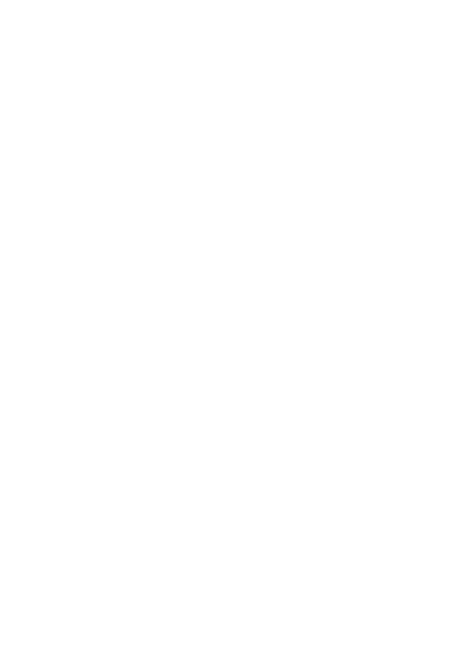

In [13]:
fig = Figure(resolution = (460,750-(7*12)),fontsize = fontsize_pub)

ds_config_12 = dynamical_summary_config(fontsize_pub,2.,ext_palette,node_colors,draw_config_12,1.5,12.,2.,1.,2.5,14.)

example_mst = 2

tr_choice = 2

min_n = length(exp_versions)*300

plot_figure_1!(fig,trajectories,embedding,8,sorted_uep,sorted_counts_uep,end_parents[top_8_mst],vertex_top_map,example_mst,tr_choice,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"Figure_2.pdf"),fig,save_fig)

fig

Phenotype transitions

In [14]:
development = DefaultGRNSolver()

const orig_network = trajectories[1].geno_traj[1]

founder = Individual(reshape(orig_network,(3,4)),grn_parameters,development)
orig_phenotype = founder.phenotype.u[end][3,:]

orig_phenotype = orig_phenotype ./ maximum(orig_phenotype);

function return_fitness_delta(fitness_orig,fitness_mutant)
    Δf1 = fitness_orig[1] - fitness_mutant[1]
    Δf2 = fitness_orig[2] - fitness_mutant[2]

    return Δf1 != 0. ? Δf1 : Δf2
end

fix_probabilities = map(tr->[fixation_probability_kim(tr.fitness_traj_tuple[i+1][1] - tr.fitness_traj_tuple[i][1],tr.fitness_traj_tuple[i+1][2] - tr.fitness_traj_tuple[i][2],β[1],β[2]) for i in 1:length(tr.fitness_traj_tuple)-1],trajectories);

fix_deltas = map(tr->[return_fitness_delta(tr.fitness_traj_tuple[i+1],tr.fitness_traj_tuple[i]) for i in 1:length(tr.fitness_traj_tuple)-1],trajectories);

neutral_indicator = map(v->map(ni -> abs(ni) .<= fitness_eps,v),fix_deltas);

In [15]:
if load_phenotype_data # load pre-computed manuscript data
    all_pheno = load(local_nb_data * "all_pheno_N6.jld2")["data"];
else # compute every phenotype associated with every mutant across all trajectories : WARNING - long computation!
    fix_probabilities = map(tr->[fixation_probability_kim(tr.fitness_traj_tuple[i+1][1] - tr.fitness_traj_tuple[i][1],tr.fitness_traj_tuple[i+1][2] - tr.fitness_traj_tuple[i][2],β[1],β[2]) for i in 1:length(tr.fitness_traj_tuple)-1],trajectories);

    fix_deltas = map(tr->[return_fitness_delta(tr.fitness_traj_tuple[i+1],tr.fitness_traj_tuple[i]) for i in 1:length(tr.fitness_traj_tuple)-1],trajectories);

    neutral_indicator = map(v->map(ni -> abs(ni) .<= fitness_eps,v),fix_deltas)

    development = DefaultGRNSolver()

    const orig_network = trajectories[1].geno_traj[1]

    founder = Individual(reshape(orig_network,(3,4)),grn_parameters,development)
    orig_phenotype = founder.phenotype.u[end][3,:]

    orig_phenotype = orig_phenotype ./ maximum(orig_phenotype);

    all_pheno = [[ni ? nothing : new_phenotype(founder,reshape(g,(3,4)),development) for (ni,g) in zip(ni_tr,tr.geno_traj[2:end])] for (ni_tr,tr) in zip(neutral_indicator,trajectories)];
end

# characterise phenotypes 

all_pheno_ch = map(tr_ph->map(ph->pheno_characterise_v1(ph,lower_bound,upper_bound,min_width),tr_ph),all_pheno);

all_pheno_mut_ch = [[characterise_mutation_v1(ph1,ph2,ni) for ((ph1,ph2),ni) in zip(zip(tr_ph[1:end-1],tr_ph[2:end]),ni)] for (tr_ph,ni) in zip(all_pheno_ch,neutral_indicator)];

replace_dict = Dict([:mrb_wbb, :crb_wlb]=>[:crb_wlb],
                    [:mlb_wbb, :crb_wlb] => [:crb_wlb],
                    [:mrb_wbb] => [:mbb_wbb],
                    [:mlb_wbb] => [:mbb_wbb],
                    [:clb_wrb,:mrb_wbb]=>[:clb_wrb],
                    [:mlb_wbb, :mrb_wbb] => [:mbb_wbb],
                    [:switch_lr] => [:other_wlb],
                    [:switch_rl] => [:other_wrb],
                    [:grow_wrb] => [:other_wrb],
                    [:grow_wlb] => [:other_wlb],
                    [:grow_wbb] => [:other_wbb],
                    [:grow_wnb] => [:other_wnb],
                    [:drb]=>[:other_wrb],
                    [:dlb]=>[:other_wlb],
                    [:nothing] => [:neutral]);

all_pheno_mut_chf = map(tr_ph->map(ph->haskey(replace_dict,ph) ? replace_dict[ph] : ph,tr_ph),all_pheno_mut_ch);

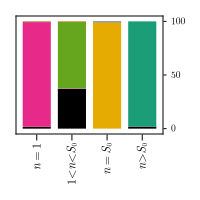

In [21]:
fig = Figure(resolution = (200,200),fontsize = fontsize_pub)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

create_pheno_transition_bars!(fig,trajectories,all_pheno_mut_chf,evo_config_12)

fig

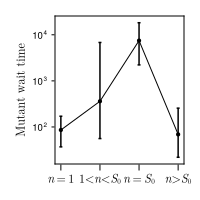

In [17]:
fig = Figure(resolution = (200,200),fontsize = fontsize_pub)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

create_wait_times!(fig,trajectories,evo_config_12,:quantile)

fig

Extract dependency relations and mutation nweight data from trajectories

In [22]:
epi_ratio_1 = map(tr->extract_minimal_weights_with_fitness(tr.epistasis[1],fitness_eps),filter(tr->(tr.H0 > 2),trajectories));
mut_n_counts_1 = reduce(vcat,map(tr->get_mut_n(tr,1,1),filter(tr->(tr.H0 > 2),trajectories)));

epi_mutn_counts_1 = countmap(mut_n_counts_1)
total_epi_mutn_1 = sum(values(epi_mutn_counts_1))
epi_mutn_prop_1 = Dict(key=>value/total_epi_mutn_1 for (key,value) in epi_mutn_counts_1)

epi_mutn_prob_1 = [epi_mutn_prop_1[i] for i in 1:4] 

##############

epi_ratio_lS0 = map(epi_vector->extract_minimal_weights_with_fitness(epi_vector,fitness_eps),reduce(vcat,map(tr->tr.epistasis[2:tr.H0-2],filter(tr->(tr.H0-2 > 0),trajectories))));
mut_n_counts_lS0 = reduce(vcat,map(tr->get_mut_n(tr,2,tr.H0-2),filter(tr->(tr.H0-2 > 0),trajectories)));

epi_mutn_counts_lS0 = countmap(mut_n_counts_lS0)
total_epi_mutn_lS0 = sum(values(epi_mutn_counts_lS0))
epi_mutn_prop_lS0 = Dict(key=>value/total_epi_mutn_lS0 for (key,value) in epi_mutn_counts_lS0);

epi_mutn_prob_lS0 = [epi_mutn_prop_lS0[i] for i in 1:4] 

#############

epi_ratio_S0 = reduce(vcat,map(tr->extract_minimal_weights_with_fitness(tr.epistasis[tr.H0-1],fitness_eps),trajectories));
mut_n_counts_S0 = reduce(vcat,map(tr->get_mut_n(tr,tr.H0-1,tr.H0-1),trajectories));

epi_mutn_counts_S0 = countmap(mut_n_counts_S0)
total_epi_mutn_S0 = sum(values(epi_mutn_counts_S0))
epi_mutn_prop_S0 = Dict(key=>value/total_epi_mutn_S0 for (key,value) in epi_mutn_counts_S0);

epi_mutn_prob_S0 = [epi_mutn_prop_S0[i] for i in 1:4] 

#############

epi_ratio_hS0 = map(epi_vector->extract_minimal_weights_with_fitness(epi_vector,fitness_eps),reduce(vcat,map(tr->tr.epistasis[tr.H0:end],trajectories)));
mut_n_counts_hS0 = reduce(vcat,map(tr->get_mut_n(tr,tr.H0,length(tr.geno_traj)-1),trajectories));

epi_mutn_counts_hS0 = countmap(mut_n_counts_hS0)
total_epi_mutn_hS0 = sum(values(epi_mutn_counts_hS0))
epi_mutn_prop_hS0 = Dict(key=>value/total_epi_mutn_hS0 for (key,value) in epi_mutn_counts_hS0);

epi_mutn_prob_hS0 = [epi_mutn_prop_hS0[i] for i in 1:4];

all_count_prop = []

for epi_v in [epi_ratio_1,epi_ratio_lS0,epi_ratio_S0,epi_ratio_hS0]

    max_nmut = maximum(last.(epi_v))

    count_mat = zeros(max_nmut,max_nmut)

    for v in epi_v
        count_mat[v[1],v[2]] += 1
    end

    count_prop = count_mat ./ sum(count_mat,dims = 1) |> transpose

    push!(all_count_prop,(count_prop,max_nmut))
end

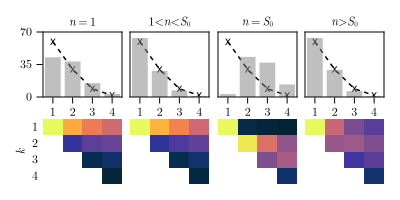

In [23]:
fig = Figure(resolution = (400,200),fontsize = fontsize_pub)

create_nweight!(fig,mut_prob,all_count_prop,epi_mutn_prob_1,epi_mutn_prob_lS0,epi_mutn_prob_S0,epi_mutn_prob_hS0)

fig

Compute mutation sizes and types

In [24]:
ph_id = findall(tr->(tr.H0-3 > 0) & (tr.H0 != length(tr.geno_traj)),trajectories);

function get_relative_size(tr,range_l,range_u,min_affinity,predict_id,vertex_to_predict_label,top_n)

    d = [tr.mutant_info[i].mut_type for i in range_l:range_u]
    w = [tr.mutant_info[i].weight_id for i in range_l:range_u]

    label = tr.inc_metagraph_vertices[tr.H0] ∈ predict_id ? vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]] : top_n + 1

    all_rel_diff = []
    all_type = []
    all_labels = []
    all_w = []
    all_sf = []

    for i in range_l:range_u
        all_sf_mut = []
        for (wi,type) in zip(tr.mutant_info[i].weight_id,tr.mutant_info[i].mut_type)
            rel_diff = abs(tr.geno_traj[i+1][wi]) - abs(tr.geno_traj[i][wi]) 
            push!(all_rel_diff,rel_diff)
            push!(all_type,type)
            push!(all_labels,label)
            push!(all_w,(wi,i))
            push!(all_sf,(sign(tr.geno_traj[i][wi]) != sign(tr.geno_traj[i+1][wi])))
        end
    end

    return all_type,all_rel_diff,all_w,all_labels,all_sf
end

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(sorted_uep[1:top_n]))

rel_data_period_1 = [get_relative_size(tr,1,1,min_affinity,sorted_uep[1:top_n],vertex_to_predict_label,top_n) for tr in trajectories[ph_id]]
rel_data_period_2 = [get_relative_size(tr,2,tr.H0-2,min_affinity,sorted_uep[1:top_n],vertex_to_predict_label,top_n)  for tr in trajectories[ph_id]]
rel_data_period_3 = [get_relative_size(tr,tr.H0-1,tr.H0-1,min_affinity,sorted_uep[1:top_n],vertex_to_predict_label,top_n)  for tr in trajectories[ph_id]]
rel_data_period_4 = [get_relative_size(tr,tr.H0,length(tr.geno_traj)-1,min_affinity,sorted_uep[1:top_n],vertex_to_predict_label,top_n) for tr in trajectories[ph_id]];

In [25]:
all_rel_sizes = []
all_mut_type = []
all_tp_ex = []
all_tp_new = []
all_tp = []

nef_prop = []
nef_prop_x = []
nef_prop_typ = []

all_p = []
all_p_x = []
all_p_typ = []

mut_type_dict = Dict((true,:additive)=>1,(false,:additive)=>2,(true,:multiplicative)=>3,(false,:multiplicative)=>4)

for (n,v) in enumerate([rel_data_period_1,rel_data_period_2,rel_data_period_3,rel_data_period_4])

    rel_sizes = Float64.(reduce(vcat,map(x->x[2],v)))

    type_s = reduce(vcat,map(x->x[1],v))

    nw = length(type_s)
    nmut = length(v)

    existing = .!first.(type_s)
    new = first.(type_s)

    sign_flip = reduce(vcat,map(x->x[5],v))

    existing_no_flip = (existing)  .& (.! sign_flip)
    existing_flip = (existing)  .& ( sign_flip)

    ft = [new[i] ? 1 : existing_no_flip[i] ? 2 : 3 for i in 1:nw]

    push!(nef_prop,[sum(new)/nw,sum(existing_no_flip)/nw,sum(existing_flip)/nw])
    push!(nef_prop_x,[n,n,n])
    push!(nef_prop_typ,[1,2,3])

    existing_sm = map(x->.!first.(x[1]),v)
    new_sm = map(x->first.(x[1]),v)
    sign_flip_sm = map(x->x[5],v)

    existing_no_flip_sm = [(existing)  .& (.! sign_flip) for (existing,sign_flip) in zip(existing_sm,sign_flip_sm)]
    existing_flip_sm = [(existing)  .& (sign_flip) for (existing,sign_flip) in zip(existing_sm,sign_flip_sm)]

    p_new = count(v->any(v),new_sm) / nmut
    p_ex = count(v->any(v),existing_no_flip_sm) / nmut
    p_fl = count(v->any(v),existing_flip_sm) / nmut

    push!(all_tp,[n for _ in 1:nw])
    push!(all_rel_sizes,rel_sizes)
    push!(all_mut_type,ft)

    push!(all_p,[p_new,p_ex,p_fl])
    push!(all_p_x,[n,n,n])
    push!(all_p_typ,[1,2,3])

end

all_rel_sizes = reduce(vcat,all_rel_sizes)

all_new_ex  = Int64.(reduce(vcat,all_mut_type))
all_tp  = reduce(vcat,all_tp);
nef_prop = reduce(vcat,nef_prop)
nef_prop_x = reduce(vcat,nef_prop_x);
nef_prop_typ = reduce(vcat,nef_prop_typ);

all_p = reduce(vcat,all_p)
all_p_x = reduce(vcat,all_p_x)
all_p_typ = reduce(vcat,all_p_typ);

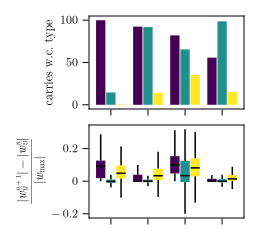

In [26]:
fig = Figure(resolution = (260,240),fontsize = fontsize_pub)

mut_color_palette = palette(:viridis, 3)

ax0 = Axis(fig[1,1],ylabel = L"\text{carries w.c. type} ", xgridvisible = false, ygridvisible = false, xticklabelsvisible = false)

ax = Axis(fig[2,1],ylabel = L"\frac{|w^{n+1}_{ij}| - |w^{n}_{ij}|}{|w_{\text{max}}|}", xgridvisible = false, ygridvisible = false, xticklabelrotation = pi/2, xticklabelsvisible = false)

CairoMakie.boxplot!(ax,all_tp,all_rel_sizes ./ abs(max_w),dodge = all_new_ex,show_outliers = false,color =  [mut_color_palette[i] for i in all_new_ex])
CairoMakie.barplot!(ax0,all_p_x,all_p,dodge = all_p_typ,color = [mut_color_palette[i] for i in all_p_typ])

ax0.yticks = ([0,0.5,1],[L"0",L"50",L"100"])
ax.yticks = ([-0.2,0,0.2],[L"-0.2",L"0",L"0.2"])

rowgap!(fig.layout,Relative(0.05))

fig

Compute epistasis types

In [27]:
all_2mut_epi_char = [[],[]]

all_neutral_corr = []
all_ne_corr = []
all_me_corr = []
all_se_corr = []
all_rse_corr = [] 

me_ex = []
rse_ex = []
se_ex = []
ne_ex = []

me_ex = []

small_lim = 1e-2

k_choice = 3


for k in 1:length(sorted_uep)
    mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);
    lmst = length(mech1_traj)

    if lmst > min_n

        mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);

        mech1_mst = map(tr->tr.minimal_stripe_subgraphs[end],mech1_traj)[1];
        
        mech1_mst_id = findall(x->x!=0,mech1_mst);

        mech1_en = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[2:end], tr.geno_traj[1:end-1])],mech1_traj)))

        epi_counts_lS0 = map(tr->tr.epistasis[1:tr.H0-2],mech1_traj);

        mut_info_lS0 = map(tr->[m.weight_id for m in tr.mutant_info[1:tr.H0-2]],mech1_traj);

        epi_counts_hS0 = map(tr->tr.epistasis[tr.H0-1:end],mech1_traj);

        mut_info_hS0 = map(tr->[m.weight_id for m in tr.mutant_info[tr.H0-1:end]],mech1_traj);

        for (n,(e_data,m_data)) in enumerate(zip([epi_counts_lS0,epi_counts_hS0],[mut_info_lS0,mut_info_hS0]))
        
            epi_info_ = [[(m,e) for (m,e) in zip(mv,ev)] for (mv,ev) in zip(m_data,e_data)];
            
            epi_info_2mut = filter(x->length(x) > 0, map(ei->filter(x->length(x[2]) == 4,ei),epi_info_));

            epi_char_2mut = map(ei->[(characterise_weight_int(wi,mech1_mst_id),type_epi(e[1],e[2],e[3],e[4],fitness_eps)) for (wi,e) in ei],epi_info_2mut);

            push!(all_2mut_epi_char[n],reduce(vcat,epi_char_2mut));
        end

        #########

        epi_types_raw = reduce(vcat,map(tr->tr.epistasis,mech1_traj))

        @assert length(epi_types_raw) == size(mech1_en,2)

        weight2_id = findall(x->length(x) == 4, epi_types_raw)

        weight2_epi_types = map(e->type_epi(e[1],e[2],e[3],e[4],fitness_eps),epi_types_raw[weight2_id])

        mech1_en_2weight = mech1_en[:,weight2_id]

        for i in 1:10
            for j in 1:10

                if i > j 

                    wi = mech1_en_2weight[i,weight2_epi_types .== :Neutral]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :Neutral]

                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_neutral_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(neutral_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10
                if i > j 
                    wi = mech1_en_2weight[i,weight2_epi_types .== :ne]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :ne]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_ne_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(ne_ex,(wi[id],wj[id],i,j))
                        end

                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j 
                    wi = mech1_en_2weight[i,weight2_epi_types .== :me]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :me]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_me_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(me_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j
                    wi = mech1_en_2weight[i,weight2_epi_types .== :se]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :se]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_se_corr,corspearman(wi[id],wj[id]))
                        if k == k_choice
                            push!(se_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j
                    wi = mech1_en_2weight[i,weight2_epi_types .== :rse]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :rse]

                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_rse_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(rse_ex,(wi[id],wj[id],i,j))
                        end
                    end
                end
            end
        end
        
    end
end

for n in [1,2]
    all_2mut_epi_char[n] = reduce(vcat,all_2mut_epi_char[n])
end

all_neutral_corr = filter(x->x ∉ [0,1],all_neutral_corr)
all_ne_corr = filter(x->x ∉ [0,1],all_ne_corr)
all_me_corr = filter(x->x ∉ [0,1],all_me_corr)
all_se_corr = filter(x->x ∉ [0,1],all_se_corr)
all_rse_corr = filter(x->x ∉ [0,1],all_rse_corr);


##########################


ls0_mst_corr = []
ls0_non_mst_corr = []
ls0_inter_mst_corr = []

hs0_mst_corr = []
hs0_non_mst_corr = []
hs0_inter_mst_corr = []

for k in 1:length(sorted_uep)
    mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);
    lmst = length(mech1_traj)

    if lmst > min_n

        mech1_mst = map(tr->tr.minimal_stripe_subgraphs[end],mech1_traj)[1];
        mech1_mst_id = findall(x->x!=0,mech1_mst);

        n_mech1_mst_id = [i for i in 1:10 if i ∉ mech1_mst_id ]

        mech1_en_lS0 = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[2:tr.H0-1], tr.geno_traj[1:tr.H0-2])],mech1_traj)))

        mech1_en_hS0 = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[tr.H0+1:end], tr.geno_traj[tr.H0:end-1])],mech1_traj)))

        for (ni,i) in enumerate(mech1_mst_id) 
            for (nj,j) in enumerate(mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

        for (ni,i) in enumerate(n_mech1_mst_id) 
            for (nj,j) in enumerate(n_mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_non_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_non_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

        for (ni,i) in enumerate(mech1_mst_id) 
            for (nj,j) in enumerate(n_mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_inter_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_inter_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

    end
end

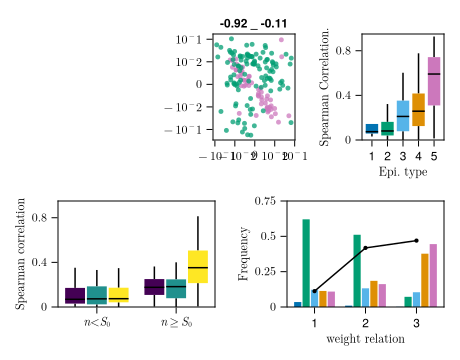

In [28]:
fig = Figure(resolution = (460,360),fontsize = fontsize_pub)

create_epi_correlation_summary!(fig,all_2mut_epi_char,[all_neutral_corr,all_ne_corr,all_me_corr,all_se_corr,all_rse_corr],[ls0_non_mst_corr,ls0_inter_mst_corr,ls0_mst_corr,hs0_non_mst_corr,hs0_inter_mst_corr,hs0_mst_corr],rse_ex,ne_ex,top_n_colors)

fig

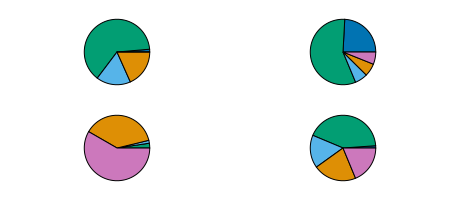

In [29]:
fig = Figure(resolution = (460,200),fontsize = fontsize_pub)

create_epi_type_counts_neutral_square!(fig,trajectories,false,false,top_n_colors,fitness_eps)

fig

Predictability analysis

In [33]:
top_n = 4

predict_id = sorted_uep[1:top_n]

label_names = 1:top_n |> collect

trajectories_p = copy(trajectories)

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex[top_n+1] = -1
labels = map(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id ? vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]] : top_n + 1,trajectories_p);

const c_types = ["c" for _ in 1:10];

const predict_colors = vcat(ext_palette[1:top_n],[:grey]);

null_H0_dist = [count(x->x==i,labels) for i in 1:top_n+1] ./ length(trajectories_p);


In [34]:
train_ttl = false
train_gtl = false

false

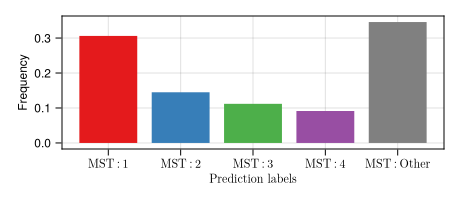

In [38]:
fig = Figure(resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],null_H0_dist, color = predict_colors[1:5])

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir_supp,"NullH0Dist.pdf"),fig,save_fig)

fig

In [39]:
ac = "DN" * string(top_n)

"DN4"

In [40]:
train_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "train")
test_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "test");

In [41]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]));

In [42]:
X_train_ttl_v_length = [reduce(hcat,[vcat(features,length(unique(tr.topologies[1:tr.H0-1]))) for features in unique(tr.topologies[1:tr.H0-1])]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl_length  = reduce(hcat,X_train_ttl_v_length) |> transpose |> collect;

length_train_ttl = copy(Int.(X_train_ttl_length[:,13]));

X_train_gtl_v_length = [reduce(hcat,[vcat(features,tr.H0-1) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl_length  = reduce(hcat,X_train_gtl_v_length) |> transpose |> collect;

length_train_gtl = copy(Int.(X_train_gtl_length[:,13]));

In [43]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

In [44]:
model_ttl = xgboost.Booster()

d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

model_ttl.load_model(local_nb_data * "ModelTTL_Other_" * ac * ".json")

ttl_prob_train = model_ttl.predict(d_train_ttl)
ttl_prob_test = model_ttl.predict(d_test_ttl)

y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);


#############


model_gtl = xgboost.Booster()

d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

model_gtl.load_model(local_nb_data * "ModelGTL_Other_" * ac * ".json")

gtl_prob_train = model_gtl.predict(d_train_gtl)
gtl_prob_test = model_gtl.predict(d_test_gtl)

y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

In [45]:
for tr in trajectories_p
    assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
end

for (tr,label) in zip(trajectories_p,labels)
    assign_tt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
    assign_gt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
end

for tr in trajectories_p
    assign_weight_edits!(tr)
end

for tr in trajectories_p
    kl_div = [i == 1 ? StatsBase.kldivergence(tr.gt_label_probabilities[1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) :  StatsBase.kldivergence(tr.gt_label_probabilities[i-1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) for i in 1:size(tr.gt_label_probabilities,1)]
    tr.gt_kl_div = kl_div
end

In [46]:
if load_shap_data
    shap_cont = load(local_nb_data * "shap_contributions_N6.jld2")["data"];

    for (tr,shap_values) in zip(trajectories_p,shap_cont)
        tr.other = shap_values
    end
else
    for tr in trajectories_p
        assign_shap!(tr,model_gtl,:gt)
    end

    save("shap_contributions_other.jld2", "data",map(x->x.other,trajectories_p))
end


In [50]:
for tr in trajectories
    cr_new = map(cr->characterise_epistasis_deltas(cr,fitness_eps),tr.epistasis)
    tr.epistasis = cr_new
end

In [51]:
ph_id = findall(tr->tr.H0 > 2,trajectories_p); # dont include any trajectories which acieved stripe on first mutation

all_epi = reduce(vcat,[tr.epistasis[1:tr.H0-2] for tr in trajectories_p[ph_id]])
all_shap = reduce(vcat,[[tr.other[n+1,:,tr.mutant_info[n].weight_id] for n in 1:tr.H0-2] for tr in trajectories_p[ph_id]])

# each entry of all_shap is a matrix n_pred_class x n_weight representing the shap explanation for the mutant
# all_epi contains the dependency evaluation for each mutant

@assert length(all_epi) == length(all_shap)

se_2mut_id = findall(x->(x[1] == :se) & (length(x[2]) == 4), all_epi);
rse_2mut_id = findall(x->(x[1] == :rse) & (length(x[2]) == 4), all_epi);

function compute_weight_importance(shap_mat)
    return sum(abs.(shap_mat),dims = 1)
end

function accept_ratio(combi_result,fitness_eps)

    accept_new_mutant = combi_result[2:end-1] .>= fitness_eps

    return accept_new_mutant
end

shap_m_se = reduce(vcat,map(x->compute_weight_importance(x),all_shap[se_2mut_id])) |> transpose |> collect
shap_m_rse = reduce(vcat,map(x->compute_weight_importance(x),all_shap[rse_2mut_id])) |> transpose |> collect;

In [52]:
# identify which is carrier (within epsilon of original fitness) versus hitchhiker 

epi_c_rse = reduce(hcat,map(x->accept_ratio(x[2],fitness_eps),all_epi[rse_2mut_id])) 
epi_c_se = reduce(hcat,map(x->accept_ratio(x[2],fitness_eps),all_epi[se_2mut_id])) 

epi_c_sef = epi_c_se[:,map(x->x[2],findall(x->x==1,sum(epi_c_se,dims = 1)))] 

# compute ration of shapley importance between carrier and hitchhiker

epi_ratio_se = reduce(vcat,[shap_m_se[epi_c_sef[:,n],n] ./ shap_m_se[.!epi_c_sef[:,n],n] for n in 1:size(epi_c_sef,2)]);

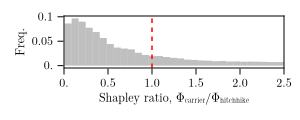

In [53]:
fig = CairoMakie.Figure(resolution = (300,120),fontsize = 12.)

ax = Axis(fig[1,1],ygridvisible = false,xgridvisible = false, xlabel = L"\text{Shapley ratio, } \Phi_{\text{carrier}} / \Phi_{\text{hitchhike}}", ylabel = L"\text{Freq.}")

CairoMakie.hist!(ax,filter(x->x < 4,epi_ratio_se),bins = 50,color = (:grey,0.5), normalization = :probability)

CairoMakie.vlines!(ax,1., color = :red, linestyle = :dash)

ax.xticks = (0:0.5:2.5,[L"0.",L"0.5",L"1.0",L"1.5",L"2.0",L"2.5"])

ax.yticks = ([0.,0.05,0.1],[L"0.",L"0.05",L"0.1"])

CairoMakie.xlims!(ax,0.,2.5)

fig

In [54]:
test_traj = findall(tr->(tr.train_test_indicator == :test) & (tr.H0 > 2),trajectories_p);

label_streak = labels[test_traj];

In [55]:

bin_boundaries = [0.,0.25,0.45,0.65,1.]

n_bins = length(bin_boundaries)-1

axis_bins = bin_boundaries[1:end-1] .+ (bin_boundaries[2:end] .- bin_boundaries[1:end-1] ) ./ 2

all_we_p = reduce(vcat,map(tr->tr.weight_edits[1:tr.H0-1] ./ tr.weight_edits[tr.H0],trajectories_p[test_traj]))

h_we = fit(Histogram, all_we_p, bin_boundaries; closed = :right)

Histogram{Int64, 1, Tuple{Vector{Float64}}}
edges:
  [0.0, 0.25, 0.45, 0.65, 1.0]
weights: [22200, 25002, 27765, 23652]
closed: right
isdensity: false

In [56]:
pred_scores_gt = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],false,:gt) for r in 1:n_bins]
pred_scores_tt = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],false,:tt) for r in 1:n_bins]
pred_scores_null = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],true,:gt) for r in 1:n_bins];

class_recall_gt = reduce(hcat,map(p->p[5],pred_scores_gt));
class_recall_tt = reduce(hcat,map(p->p[5],pred_scores_tt));

total_accuracy_gt = map(p->p[1],pred_scores_gt);
total_accuracy_tt = map(p->p[1],pred_scores_tt);
total_accuracy_null = map(p->p[1],pred_scores_null);

f1_macro_gt = map(p->p[3],pred_scores_gt);
f1_macro_tt = map(p->p[3],pred_scores_tt);
f1_macro_null = map(p->p[3],pred_scores_null);

av_we = map(p->p[6],pred_scores_gt);

f1_class_gt = reduce(hcat,map(p->p[4],pred_scores_gt));

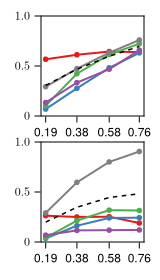

In [57]:
fig = Figure(resolution = (160,280),fontsize = fontsize_pub)

ax1 = Axis(fig[1,1],xgridvisible = false,ygridvisible = false)
ax2 = Axis(fig[2,1],xgridvisible = false,ygridvisible = false)

axis_bins = copy(av_we)

for n in 1:top_n+1
    l1 = CairoMakie.lines!(ax1,axis_bins,class_recall_gt[n,:],color = predict_colors[n],linewidth = 2.)
    l1 = CairoMakie.lines!(ax2,axis_bins,class_recall_tt[n,:],color = predict_colors[n],linewidth = 2.)
    CairoMakie.scatter!(ax1,axis_bins,class_recall_gt[n,:],color = predict_colors[n],markersize = 8.)
    CairoMakie.scatter!(ax2,axis_bins,class_recall_tt[n,:],color = predict_colors[n],markersize = 8.)
end

CairoMakie.lines!(ax1,axis_bins,total_accuracy_gt, linestyle = :dash,color = :black)
CairoMakie.lines!(ax2,axis_bins,total_accuracy_tt, linestyle = :dash,color = :black)

ax1.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax1.yticks = ([0,0.5,1.], [L"0",L"0.5",L"1.0"])

CairoMakie.ylims!(ax1,0.,1.)

ax2.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax2.yticks = ([0,0.5,1.], [L"0",L"0.5",L"1.0"])

CairoMakie.ylims!(ax2,0.,1.)


colgap!(fig.layout, Relative(0.02))
rowgap!(fig.layout, Relative(0.02))


fig

In [58]:
predict_mst = [vertex_top_map[id] for id in predict_id];
predict_mst_complexity = [sum(abs.(v)) for v in predict_mst];

Retrieve target mutants for contingency analysis

In [59]:
mut_n = 1
n_weight = 2

all_target_mutants = []
all_target_networks = []
all_target_prob = []
all_target_ent_deltas = []
all_target_max_ent = []

for n in 1:top_n+1

    if n == top_n+1
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == -1 ,trajectories_p)
    else
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == sorted_uep[n],trajectories_p)
    end

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    target_mutant_id = findall(sample_top_edits_delta_select .== n_weight) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id[1]]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)
    push!(all_target_prob,target_prob)
    push!(all_target_max_ent,max_ent_delta)
    push!(all_target_ent_deltas,sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))
end

Load contingency experiments 

In [63]:
contingency_data = Dict()

all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_Contingent_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Double"] = [all_target_networks,all_target_prob,vim_trajectories,all_target_ent_deltas,all_target_max_ent,all_target_mutants];

MST: 1 - 1.0


MST: 2 - 0.964


MST: 3 - 0.6882


MST: 4 - 0.9856


MST: 5 - 0.732


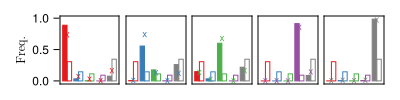

In [64]:
fig = CairoMakie.Figure(resolution = (400,100),fontsize = 12.)

create_contingency_accuracy_summary!(fig,contingency_data["Double"][3],contingency_data["Double"][2],null_H0_dist,top_n,predict_label_to_vertex,predict_colors)

fig